# Stabilizer Code on IBM Quantum Computers

Use [4,2,2] stabilizer code to extend coherence times

In [134]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

from qiskit import *
IBMQ.load_account()

import pickle
import random
from itertools import permutations
from itertools import product

/Users/Razander/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


# Generate Realizable Group R(2)
helpful [implementation](https://github.com/Octophi/quantum_rb/blob/master/Find%20R(2)%20.ipynb)


There are 576 elements in this group. The generates are $X_1$, $X_2$, $Z_1$, $Z_2$, $CNOT_{1,2}$, $CNOT_{2,1}$, $SWAP_{1,2} (H_1 H_2)$, $(Z_1 Z_2) CZ_{1,2}$

In [2]:
# Single qubit gates in single qubit Hilbert space
x = np.array([[0,1],[1,0]])
iden = np.identity(2)
z = np.array([[1,0],[0,-1]])
h = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

# Logic gates for two qubits in [4,2,2] code. Generators of R(2) group.
X1 = np.kron(iden, x)
X2 = np.kron(x, iden)
Z1 = np.kron(iden, z)
Z2 = np.kron(z, iden)
CNOT12 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
CNOT21 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])
SWAP12_H1H2 = np.matmul(np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]), np.kron(h, h))
Z1Z2_CZ12 = np.matmul(np.kron(z, z), np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]]))

### R(2) group element generation

In [3]:
# Initialize R(2) group
r2_group = {}
r2_group['0'] = np.identity(4)
r2_group['1'] = X1
r2_group['2'] = X2
r2_group['3'] = Z1
r2_group['4'] = Z2
r2_group['5'] = SWAP12_H1H2
r2_group['6'] = Z1Z2_CZ12
r2_group['7'] = CNOT12
r2_group['8'] = CNOT21

In [4]:
# temporary storage of R(2) group elements. Helpful in generating R(2) group elements from generators
r2_group_previous = {} 
r2_group_previous['1'] = X1
r2_group_previous['2'] = X2
r2_group_previous['3'] = Z1
r2_group_previous['4'] = Z2
r2_group_previous['5'] = SWAP12_H1H2
r2_group_previous['6'] = Z1Z2_CZ12
r2_group_previous['7'] = CNOT12
r2_group_previous['8'] = CNOT21

for n in range(1, 9):
    r2_group_new = {}  # temporary storage of R(2) group elements
    for key_str, gate in r2_group_previous.items():
        for i in range(1, 9):
            if str(i) == key_str[-1]:  # don't consider sqaure of a gate
                continue
            new_key = key_str + str(i)
            # make new gate based on new_key
            new_gate = np.identity(4)
            for j in new_key:
                new_gate = np.matmul(new_gate, r2_group[j])
            new_gate = np.around(new_gate, decimals = 2)
            # Check if matrix has already been added to group
            unique = True
            for gate in r2_group_new.values():
                rounded_new_gate = np.around(new_gate, decimals = 2)
                rounded_gate = np.around(gate, decimals = 2)
                if np.array_equal(rounded_gate, rounded_new_gate) or np.array_equal(rounded_gate, -1*rounded_new_gate):
                    unique = False
                    break
            for gate in r2_group.values():
                rounded_new_gate = np.around(new_gate, decimals = 2)
                rounded_gate = np.around(gate, decimals = 2)
                if np.array_equal(rounded_gate, rounded_new_gate) or np.array_equal(rounded_gate, -1*rounded_new_gate):
                    unique = False
                    break
            # If new_gate has not been added to R(2) group, add it to R(2) group
            if unique:
                r2_group_new[new_key] = new_gate
    r2_group.update(r2_group_new)  # update r2_group with new gates
    r2_group_previous = r2_group_new  # new gates will be considered "previous" on next iteration
    print('loop:', n)
    print('new R(2) group elements:', len(list(r2_group_new.keys())))


loop: 1
new keys: 36
loop: 2
new keys: 101
loop: 3
new keys: 157
loop: 4
new keys: 146
loop: 5
new keys: 88
loop: 6
new keys: 33
loop: 7
new keys: 6
loop: 8
new keys: 0


In [5]:
len(r2_group)

576

### Save R(2) group for later

In [6]:
# Save R(2) group dictionary r2_group
# filename = 'r2_group.pkl'
# outfile = open(filename, 'wb')
# pickle.dump(r2_group, outfile)
# outfile.close()

In [7]:
# Get R(2) group elements from r2_group.pkl file
filename = 'r2_group.pkl'
infile = open(filename,'rb')
r2_group = pickle.load(infile)
infile.close()

In [8]:
len(r2_group)

576

### Make random selection of R(2) gates

In [11]:
# Generate random selection of gates from R(2). Return concatenated string indicies for selection.
def randR2Gates(n):
    random.seed(a=2)
    rand_gate_ind = ''
    for _ in range(n):
        rand_gate_ind = ''.join([rand_gate_ind, random.choice(list(r2_group.keys()))])
    return rand_gate_ind

# Unencoded Randomized Benchmarking with R(2)

In [16]:
def init_state(state, qubit_map, qc, qr):
    qc.barrier()
    if state == '01':
        qc.x(qr[qubit_map[0]])
    elif state == '10':
        qc.x(qr[qubit_map[1]])
    elif state == '11':
        qc.x(qr[qubit_map[0]])
        qc.x(qr[qubit_map[1]])
    qc.barrier()

# Assume only 2 qubits
def swap(qubit_map):
    new_qubit_map = {}
    new_qubit_map[0] = qubit_map[1]
    new_qubit_map[1] = qubit_map[0]
    return new_qubit_map

def addGate(i, qubit_map, qr, qc, inverse=False):
    if i == '1':
        qc.x(qr[qubit_map[0]])        
    elif i == '2':
        qc.x(qr[qubit_map[1]])
    elif i == '3':
        qc.z(qr[qubit_map[0]])
    elif i == '4':
        qc.z(qr[qubit_map[1]])
    elif i == '5':
        if inverse:
            qubit_map = swap(qubit_map)
            qc.h(qr[qubit_map[0]])
            qc.h(qr[qubit_map[1]])
        else:
            qc.h(qr[qubit_map[0]])
            qc.h(qr[qubit_map[1]])
            qubit_map = swap(qubit_map)
    elif i == '6':
        if inverse:
            qc.z(qr[qubit_map[0]])
            qc.z(qr[qubit_map[1]])
            qc.cz(qr[qubit_map[0]], qr[qubit_map[1]])
        else:
            qc.cz(qr[qubit_map[0]], qr[qubit_map[1]])
            qc.z(qr[qubit_map[0]])
            qc.z(qr[qubit_map[1]])
    elif i == '7':
        qc.cx(qr[qubit_map[0]], qr[qubit_map[1]])
    elif i == '8':
        qc.cx(qr[qubit_map[1]], qr[qubit_map[0]])
    else:
        print(' --- Error ---\nExceeded gate range')
    qc.barrier()

# Add random set of gates selected by randR2Gates. Includes gate inverses as well
def addRandGates(rand_gate_indices, qubit_map, qr, qc):
    # Add gates based on random index
    for gate_indices in rand_gate_indices:
        for gate in gate_indices:
            addGate(gate, qubit_map, qr, qc)
    # Add inverse of gates
    for gate_indices in rand_gate_indices[::-1]:
        for gate in gate_indices:
            addGate(gate, qubit_map, qr, qc, inverse=True)

In [159]:
def unencoded_rb(half_circuit_length, initial_state, shots, backend):
    n_qubits = 2
    qubit_map = {}  # used to track virtual swaps
    for i in range(n_qubits):
        qubit_map[i] = i

    # Initialize quantum circuit and registers
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(qr, cr)
    
    # Initialize quantum state
    init_state(initial_state, qubit_map, qc, qr)
    # Add randomized gates (along with inverses)
    rand_gate_indices = randR2Gates(half_circuit_length)
    addRandGates(rand_gate_indices, qubit_map, qr, qc)
    # Measure qubits
    for i in range(n_qubits):
        qc.measure(i, i)

    # Execute quantum circuit
    result = execute(qc, backend, shots=shots).result()
    return result, qc

### Find least busy 5 qubit quantum computer

In [155]:
# Filter backends to find the least busy 5 qubit quantum computer and check current "pending_jobs"
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
smaller_qcs = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
backend_real = least_busy(smaller_qcs)

# Check status and "pending_jobs" to see how long it might take to run
backend_real.status()

BackendStatus(backend_name='ibmq_burlington', backend_version='1.1.4', operational=True, pending_jobs=2, status_msg='active')

### Start up simulator backend

In [ ]:
backend_sim = BasicAer.get_backend('qasm_simulator')

### Test experiment

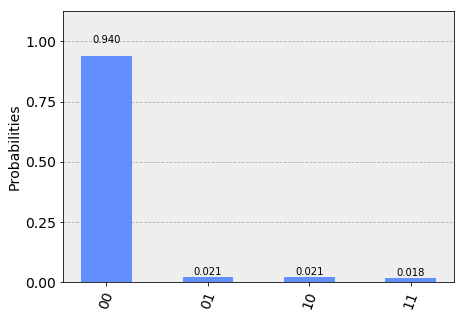

In [160]:
half_circuit_length = 0
state = '00'
shots = 8192

result, qc = unencoded_rb(half_circuit_length, state, shots, backend_real)
counts = result.get_counts(qc)
visualization.plot_histogram(counts)

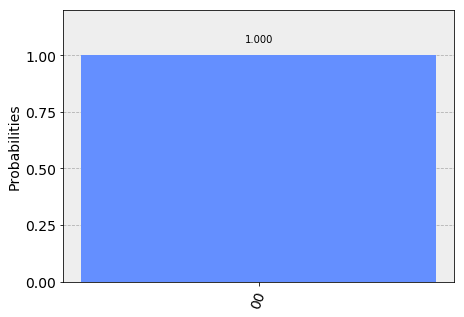

In [27]:
half_circuit_length = 6
state = '00'
shots = 8192

result, qc = unencoded_rb(half_circuit_length, state, shots, backend_sim)
counts = result.get_counts(qc)
visualization.plot_histogram(counts)

### Execute experiment over all states and variable circuit length

In [280]:
half_circuit_lengths = np.arange(0, 50, 5)
states = ['00', '01', '10', '11']
shots = 8192
n_reps = 5

# Initialize dictionaries that will save results
results = {}
qcs = {}

for i in tnrange(n_reps, desc='rep'):
    results[i] = {}
    qcs[i] = {}
    for half_circuit_length in half_circuit_lengths:
        results[i][half_circuit_length] = {}
        qcs[i][half_circuit_length] = {}
        for state in states:
            result, qc = unencoded_rb(half_circuit_length, state, shots, backend_real)
            results[i][half_circuit_length][state] = result
            qcs[i][half_circuit_length][state] = qc

KeyboardInterrupt: 

### Organize output dictionaries into dataframe

In [ ]:
# Store results in pandas dataframe

columns = ['cir_len', 'init_state', '00', '01', '10', '11']
df = pd.DataFrame(columns=columns)
for i in results.keys():
    for half_circuit_length in results[i].keys():
        for state, res in results[i][half_circuit_length].items():
            counts = res.get_counts()
            # build dataframe row from counts dictionary
            length = half_circuit_length * 2 - 1
            if length < 0:
                length = 0
            df_row = counts.copy()
            df_row['cir_len'] = length
            df_row['init_state'] = state
            if df.empty:
                df = pd.DataFrame(data=df_row, index=[0])
            else:
                df = df.append(df_row, ignore_index=True)

In [284]:
# filename = './unencoded_data.pkl'
# df.to_pickle(filename)
df.head(6)

,10,00,11,01,cir_len,init_state,q_ave
0,1145,4095,1500,1452,10,00,0.499878
1,1059,1845,1054,4234,10,01,0.516846
2,4331,1397,1099,1365,10,10,0.528687
3,1430,1260,4191,1311,10,11,0.511597
4,1093,4013,1308,1778,20,00,0.489868
5,1226,1541,1311,4114,20,01,0.502197


### Compute average survival $\bar{q}$

In [283]:
# Got to be a better way to do this
df['q_ave'] = np.diag(df[df.loc[:,'init_state']].values) / shots

In [481]:
df.head()

,10,00,11,01,cir_len,init_state,q_ave
0,1145,4095,1500,1452,10,00,0.499878
1,1059,1845,1054,4234,10,01,0.516846
2,4331,1397,1099,1365,10,10,0.528687
3,1430,1260,4191,1311,10,11,0.511597
4,1093,4013,1308,1778,20,00,0.489868


### Fit Fidelity parameters

In [554]:
rho00_cir_lens = df[df['init_state'] == '00'].sort_values(by='cir_len')['cir_len'].values
rho00_q_aves = df[df['init_state'] == '00'].sort_values(by='cir_len')['q_ave'].values

fit parameters: [0.35600665 0.97624069]
variances: [7.31860184e-05 6.19607515e-07]


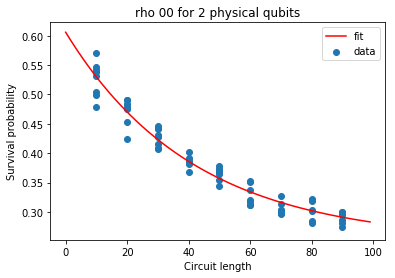

In [555]:
def exp(x, B, b):
    return 0.25 + B * b**x

guess = [0.953, .356]
popt, pcov = curve_fit(exp, rho00_cir_lens, rho00_q_aves, p0=guess)
print('fit parameters:', popt)
print('variances:', np.diag(pcov))
B = popt[0]
b = popt[1]

x = np.arange(0, 100)
plt.plot(x, exp(x, *popt), '-r')
plt.scatter(rho00_cir_lens, rho00_q_aves)
plt.title('rho 00 for 2 physical qubits')
plt.xlabel('Circuit length')
plt.ylabel('Survival probability')
plt.legend(['fit','data'])
plt.show()

In [556]:
b_std = np.sqrt(pcov[1,1])

In [557]:
q_aves_all = df.sort_values(by=['cir_len'])['q_ave'].values
cir_lens_all = df.sort_values(by=['cir_len'])['cir_len'].values

fit parameters: [0.04391206 0.83915374]
variances: [0.03763829 0.12557221]
little c: 0.8391537430536916


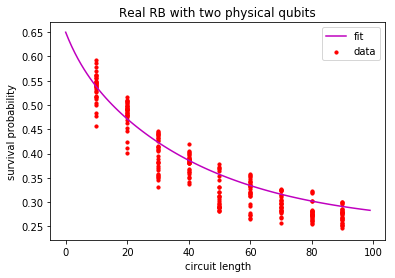

In [713]:
def double_exp(x, B, b, C, c):
    return 0.25 + B * b**x + C * c**x

guess = [0.05, 0.356]
popt, pcov = curve_fit(lambda x, C, c: double_exp(x, B, b, C, c), cir_lens_all, q_aves_all, p0=guess, bounds=([0,0],[1,1]))
print('fit parameters:', popt)
print('variances:', np.diag(pcov))
c = popt[1]
print('little c:', c)

x = np.arange(0, 100)
plt.plot(x, double_exp(x, *[B,b,*popt]), '-m')
plt.scatter(cir_lens_all, q_aves_all, color='r', s=10)
plt.title('Real RB with two physical qubits')
plt.xlabel('circuit length')
plt.ylabel('survival probability')
plt.legend(['fit','data'])
plt.savefig('survival_unencoded.png')
plt.show()

In [559]:
c_std = np.sqrt(pcov[1,1])
c_std

0.3543616889565039

In [560]:
b_std

0.0007871515198468396

In [561]:
fidelity = (9*b + 6*c + 5) / 20
print('Infidelity:', round((1 - fidelity)*100, 5), '%')

Infidelity: 5.89456 %


In [564]:
print((9*(b+b_std) + 6*(c+c_std)+ 5) / 20, 1 - (9*(b-b_std) + 6*(c-c_std) + 5) / 20)

1.0477171587565448 0.1656082909852199


# Encoded Randomized Benchmark with R(2)

In [314]:
def init_state_enc(state, qubit_map, qc, qr):
    qc.barrier()
    # initialize '00' state
    qc.h(qr[qubit_map[1]])
    qc.cx(qr[qubit_map[1]],qr[qubit_map[0]])
    qc.cx(qr[qubit_map[1]],qr[qubit_map[2]])
    qc.cx(qr[qubit_map[2]],qr[qubit_map[3]])
    qc.barrier()
    if state == '01':
        qc.x(qr[qubit_map[0]])
        qc.x(qr[qubit_map[1]])
    elif state == '10':
        qc.x(qr[qubit_map[0]])
        qc.x(qr[qubit_map[2]])
    elif state == '11':
        qc.x(qr[qubit_map[1]])
        qc.x(qr[qubit_map[2]])
    qc.barrier()

def swap_enc(qubit_map, q_i, q_j):
    new_qubit_map = {}
    new_qubit_map[q_i] = qubit_map[q_j]
    new_qubit_map[q_j] = qubit_map[q_i]
    return new_qubit_map

def addGate_enc(i, qubit_map, qr, qc, inverse=False):
    if i == '1':
        qc.x(qr[qubit_map[2]])
        qc.x(qr[qubit_map[3]])
    elif i == '2':
        qc.x(qr[qubit_map[0]])
        qc.x(qr[qubit_map[2]])
    elif i == '3':
        qc.z(qr[qubit_map[2]])
        qc.z(qr[qubit_map[3]])
    elif i == '4':
        qc.z(qr[qubit_map[0]])
        qc.z(qr[qubit_map[2]])
    elif i == '5':
        qc.h(0)
        qc.h(1)
        qc.h(2)
        qc.h(3)
    elif i == '6':
        if inverse:
            qc.sdg(0)
            qc.sdg(1)
            qc.sdg(2)
            qc.sdg(3)
        else:
            qc.s(0)
            qc.s(1)
            qc.s(2)
            qc.s(3)
    elif i == '7':
        qubit_map = swap_enc(qubit_map, 2, 3)
    elif i == '8':
        qubit_map = swap_enc(qubit_map, 1, 3)
    else:
        print(' --- Error ---\nExceeded gate range')
    qc.barrier()

# Add random set of gates selected by randR2Gates. Includes gate inverses as well
def addRandGates_enc(rand_gate_indices, qubit_map, qr, qc):
    # Add gates based on random index
    for gate_indices in rand_gate_indices:
        for gate in gate_indices:
            addGate_enc(gate, qubit_map, qr, qc)
    # Add inverse of gates
    for gate_indices in rand_gate_indices[::-1]:
        for gate in gate_indices:
            addGate_enc(gate, qubit_map, qr, qc, inverse=True)

In [345]:
def encoded_rb(half_circuit_length, initial_state, shots, backend):
    n_qubits = 4
    qubit_map = {}  # used to track virtual swaps
    for i in range(n_qubits):
        qubit_map[i] = i

    # Initialize quantum circuit and registers
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(qr, cr)
    
    # Initialize quantum state
    init_state_enc(initial_state, qubit_map, qc, qr)
    # Add randomized gates (along with inverses)
    rand_gate_indices = randR2Gates(half_circuit_length)
    addRandGates_enc(rand_gate_indices, qubit_map, qr, qc)
    # Measure qubits
    for i in range(n_qubits):
        qc.measure(i, i)

    # Execute quantum circuit
    result = execute(qc, backend, shots=shots).result()
    return result, qc

### Test runs 

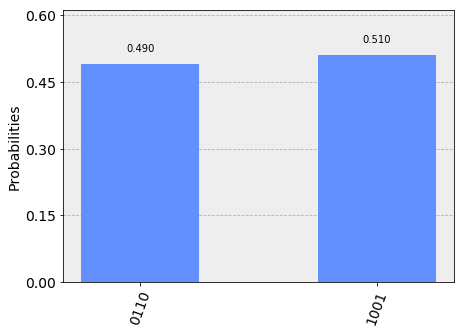

In [347]:
half_circuit_length = 4
state = '11'
shots = 8192

result, qc = encoded_rb(half_circuit_length, state, shots, backend_sim)
counts = result.get_counts(qc)
visualization.plot_histogram(counts)

In [350]:
# Filter backends to find the least busy 5 qubit quantum computer and check current "pending_jobs"
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub='ibm-q')
smaller_qcs = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
backend_real = least_busy(smaller_qcs)

# Check status and "pending_jobs" to see how long it might take to run
backend_real.status()

BackendStatus(backend_name='ibmq_burlington', backend_version='1.1.4', operational=True, pending_jobs=3, status_msg='active')

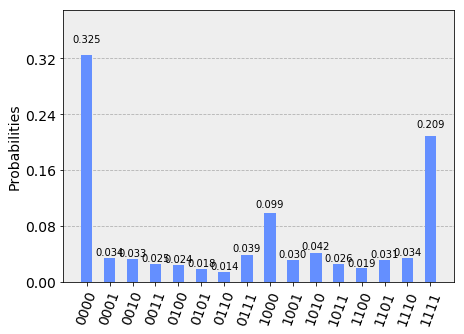

In [349]:
half_circuit_length = 2
state = '00'
shots = 8192

result, qc = encoded_rb(half_circuit_length, state, shots, backend_real)
counts = result.get_counts(qc)
visualization.plot_histogram(counts)

### Execute experiment over all states and variable circuit length

In [352]:
half_circuit_lengths_en = np.arange(0, 50, 5)
states = ['00', '01', '10', '11']
shots = 8192
n_reps = 5

# Initialize dictionaries that will save results
results_en = {}
qcs_en = {}

for i in tnrange(n_reps, dsec='reps'):
    results_en[i] = {}
    qcs_en[i] = {}
    for half_circuit_length in half_circuit_lengths_en:
        results_en[i][half_circuit_length] = {}
        qcs_en[i][half_circuit_length] = {}
        for state in states:
            result, qc = encoded_rb(half_circuit_length, state, shots, backend_real)
            results_en[i][half_circuit_length][state] = result
            qcs_en[i][half_circuit_length][state] = qc

Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocket, retrying using HTTP.
Error checking job status using websocke

KeyboardInterrupt: 

### Organize output dictionaries into dataframe

In [384]:
# Store results in pandas dataframe
columns = ['cir_len', 'init_state', '0000', '0001', '0010', '0100', '1000', '0011', '0101', '1001', '0110', '1010', '1100', '0111', '1011', '1101', '1110', '1111']
df_en = pd.DataFrame(columns=columns)
for i in results_en.keys():
    for half_circuit_length in results_en[i].keys():
        for state, res in results_en[i][half_circuit_length].items():
            counts = res.get_counts()
            # build dataframe row from counts dictionary
            df_row = counts.copy()
            length = half_circuit_length * 2 - 1
            if length < 0:
                length = 0
            df_row['cir_len'] = length
            df_row['init_state'] = state
            if df_en.empty:
                df_en = pd.DataFrame(data=df_row, index=[0])
            else:
                df_en = df_en.append(df_row, ignore_index=True)

In [385]:
results_en.keys()

dict_keys([0, 1, 2])

In [515]:
# filename = './encoded_data.pkl'
# df_en.to_pickle(filename)
df_en.head(6)

,0011,1001,0111,0000,0100,1000,0010,1010,0101,0001,0110,1100,1101,1110,1111,1011,cir_len,init_state
0,98,33,172,3821,141,140,131,59,44,276,51,294,226,491,2090,125,0,00
1,3078,312,105,282,241,175,490,59,126,582,116,1864,310,100,135,217,0,01
2,100,281,115,115,376,314,227,2088,3332,371,105,125,145,189,71,238,0,10
3,138,1915,203,150,550,381,269,173,201,266,3121,359,90,243,51,82,0,11
4,156,208,311,2347,509,312,157,252,504,454,135,253,381,399,1440,374,9,00
5,2519,267,536,121,223,381,520,173,164,289,259,1738,315,197,270,220,9,01


### Remove states not part of the codespace

In [571]:
codespace = ['0000', '1111', '1100', '0011', '0101', '1010', '1001', '0110']
new_columns = df_en.columns
df_en_codespace = df_en[new_columns[np.isin(new_columns, codespace + ['cir_len','init_state'])]]
df_en_codespace.head(6)

,0011,1001,0000,1010,0101,0110,1100,1111,cir_len,init_state
0,98,33,3821,59,44,51,294,2090,0,00
1,3078,312,282,59,126,116,1864,135,0,01
2,100,281,115,2088,3332,105,125,71,0,10
3,138,1915,150,173,201,3121,359,51,0,11
4,156,208,2347,252,504,135,253,1440,9,00
5,2519,267,121,173,164,259,1738,270,9,01


### Compute average survival $\bar{q}$

In [699]:
# Got to be a better way to do this
state_map = {'00':['0000','1111'], '01':['1100','0011'], '10':['0101','1010'], '11':['0110','1001']}
state_map1 = {'00':'0000', '01':'1100', '10':'0101', '11':'0110'}
state_map2 = {'00':'1111', '01':'0011', '10':'1010', '11':'1001'}

# Compare superposition of states. add two states associated with logical state and divide by number of shots in coding space
temp = df_en_codespace.loc[:,'init_state'].map(state_map1)
df_en_codespace['state1'] = np.diag(df_en_codespace[temp].values)
temp = df_en_codespace.loc[:,'init_state'].map(state_map2)
df_en_codespace['state2'] = np.diag(df_en_codespace[temp].values)
df_en_codespace['shots'] = df_en_codespace[codespace].sum(axis=1)
df_en_codespace['q_ave'] = df_en_codespace[['state1','state2']].sum(axis=1) / df_en_codespace['shots']

df_en_codespace.head(6)

/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Razander/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,0011,1001,0000,1010,0101,0110,1100,1111,cir_len,init_state,state1,state2,shots,q_ave
0,98,33,3821,59,44,51,294,2090,0,00,3821,2090,6490,0.910786
1,3078,312,282,59,126,116,1864,135,0,01,1864,3078,5972,0.827528
2,100,281,115,2088,3332,105,125,71,0,10,3332,2088,6217,0.871803
3,138,1915,150,173,201,3121,359,51,0,11,3121,1915,6108,0.824492
4,156,208,2347,252,504,135,253,1440,9,00,2347,1440,5295,0.715203
5,2519,267,121,173,164,259,1738,270,9,01,1738,2519,5511,0.772455


### Fit Fidelity parameters

In [700]:
q_aves_all_enc = df_en_codespace.sort_values(by=['cir_len'])['q_ave'].values
cir_lens_all_enc = df_en_codespace.sort_values(by=['cir_len'])['cir_len'].values

fit parameters: [0.47956885 0.99520946 0.06321915 0.99520976]
variances: [1.14133695e+13 6.11481701e+03 1.14133695e+13 3.52026765e+05]


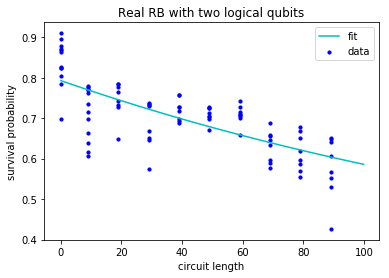

In [712]:
def double_exp(x, B, b, C, c):
    return 0.25 + B * b**x + C * c**x

guess = [0.5, 0.90, 0.1, 0.9]
# popt_enc, pcov_enc = curve_fit(lambda x, C_enc, c_enc: double_exp(x, B_enc, b_enc, C_enc, c_enc), cir_lens_all_enc, q_aves_all_enc, p0=guess, bounds=([0, 0], [1,1]))
popt_enc, pcov_enc = curve_fit(double_exp, cir_lens_all_enc, q_aves_all_enc, p0=guess, bounds=([0,0,0,0], [1,1,1,1]))
print('fit parameters:', popt_enc)
print('variances:', np.diag(pcov_enc))
B_enc = popt_enc[0]
b_enc = popt_enc[1]
C_enc = popt_enc[2]
c_enc = popt_enc[3]

x = np.arange(0, 1000) / 10
# plt.plot(x, double_exp(x, *[B_enc, b_enc, *popt_enc]), '-r')
plt.plot(x, double_exp(x, *popt_enc), '-c')
plt.scatter(cir_lens_all_enc, q_aves_all_enc, color='b', s=10)
plt.title('Real RB with two logical qubits')
plt.xlabel('circuit length')
plt.ylabel('survival probability')
plt.legend(['fit','data'])
plt.savefig('survival_encoded.png')
plt.show()

In [702]:
b_enc, c_enc

(0.9952094564962237, 0.9952097566148572)

In [703]:
fidelity = (9*b_enc + 6*c_enc + 5) / 20
print('Infidelity:', round((1 - fidelity)*100, 5), '%')

Infidelity: 0.35928 %


# Comparison between encoded and unencoded RB

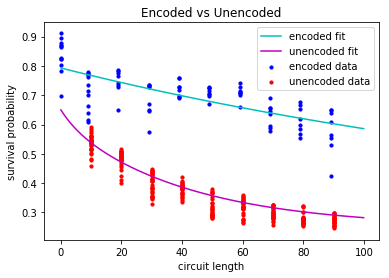

In [711]:
x = np.arange(0, 1000) / 10
plt.plot(x, double_exp(x, *popt_enc), '-c')
plt.plot(x, double_exp(x, *[B, b, *popt]), '-m')
plt.scatter(cir_lens_all_enc, q_aves_all_enc, color='b', s=10)
plt.scatter(cir_lens_all, q_aves_all, color='r', s=10)
plt.title('Encoded vs Unencoded')
plt.xlabel('circuit length')
plt.ylabel('survival probability')
plt.legend(['encoded fit','unencoded fit','encoded data','unencoded data'])
plt.savefig('survival_comparison.png')
plt.show()

# Circuit Images

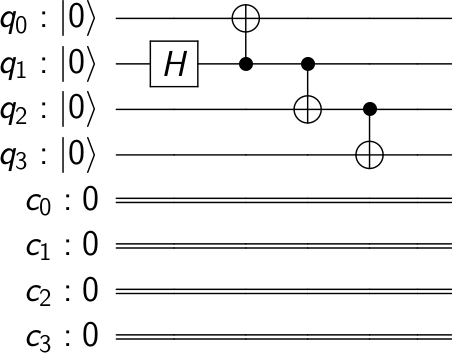

In [514]:
## Logical |00> state preparation
n_qubits = 4

# Initialize quantum circuit and registers
qc = QuantumCircuit(4,4)

# initialize '00' state
qc.h(1)
qc.cx(1, 0)
qc.cx(1, 2)
qc.cx(2, 3)

qc.draw(filename='psi_00_prep.png',output='latex', plot_barriers=False)

# References
[1](https://arxiv.org/pdf/1806.02359v4.pdf) Fault-Tolerant Logical Gates in the IBM Quantum Experience. R. Harper1 and S. T. Flammia. (2019)